In [1]:
from deep_q_network import DQNAgent
from double_deep_q_network import DoubleDQNAgent

from base_rl_agent_torch import ReplayMemory
from base_neural_model import EstimatorModelBase
from advantage_neural_model import AdvantageModel
import utils
import random
import copy
from Data_binary import *

In [2]:
# Fix seeds for reproducibility.
#utils.fix_seeds()

In [3]:
env = Data(unknown_rate=1)
env.loadfile("heart.csv")
env.normalize()
env.alpha = 0
env.cluster_K_means(7)
# makes the costs uniform
#env.set_costs()
# this are official costs listed at the time from OHIP fee schedule
costs = [1, 1, 1, 1, 7.27, 5.20, 15.5, 102.9, 87.3, 87.3, 87.3, 100.9, 102.9]
total_cost = sum(costs)
costs = [costs[i]/total_cost for i in range(len(costs))]
env.set_costs(costs)
# setting groups, where getting a single attribute of the group gives the rest for free
groups = [[8,9,10],[7,12]]
env.set_groups(groups)
# max_cost is the fixed maximum cost the agent can take
env.max_cost = 0.16
# partition into training/test sets
test_env = env.split(0.80)
print("costs:",costs)

costs: [0.0016650848360723978, 0.0016650848360723978, 0.0016650848360723978, 0.0016650848360723978, 0.01210516675824633, 0.008658441147576468, 0.025808814959122166, 0.17133722963184975, 0.14536190618912032, 0.14536190618912032, 0.14536190618912032, 0.16800705995970494, 0.17133722963184975]


In [4]:
MAX_EPISODES = 4000
MAX_STEPS = 15
BATCH_SIZE = 32
buffer = ReplayMemory(100)

# Initiate the agent
model = AdvantageModel
agent = DQNAgent(env, 
                       model, 
                       buffer,max_steps=MAX_STEPS, 
                       max_episodes=MAX_EPISODES,
                       gamma=0.7,
                       epsilon_decay=0.9995,
                       exploration_penalty=-0.01,
                       verbose=0 # Verbosity level
                      )

In [5]:
#Train
episode_rewards = agent.train(env, MAX_EPISODES, MAX_STEPS, BATCH_SIZE)

We want to plot the reward per episode to examine agent performance.

In [6]:
def plot_reward_per_episode(episode_rewards):
    import matplotlib.pyplot as plt
    episode_rewards = episode_rewards[0:1000]
    x = [i for i in range(len(episode_rewards))]
    plt.plot(x, episode_rewards)
    
plot_reward_per_episode(episode_rewards)

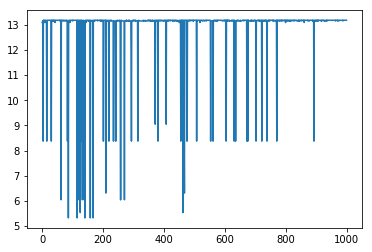

In [7]:
def plot_reward_per_episode(episode_rewards):
    import matplotlib.pyplot as plt
    episode_rewards = episode_rewards[4000:5000]
    x = [i for i in range(len(episode_rewards))]
    plt.plot(x, episode_rewards)
    
plot_reward_per_episode(episode_rewards)

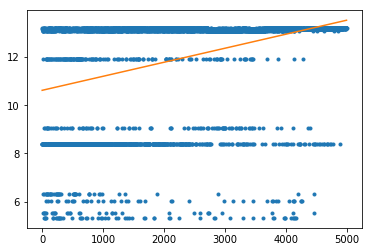

In [8]:
def plot_reward_per_episode(episode_rewards):
    import matplotlib.pyplot as plt
    episode_rewards = episode_rewards[0:5000]
    x = [i for i in range(len(episode_rewards))]
    plt.plot(x, episode_rewards,'.')
    x = np.array(x).reshape(-1,1)
    episode_rewards = np.array(episode_rewards).reshape(-1,1)
    from sklearn import datasets, linear_model
    regr = linear_model.LinearRegression()
    regr.fit(x,episode_rewards)
    y_pred = regr.predict(x)
    plt.plot(x,y_pred,'-')
    
plot_reward_per_episode(episode_rewards)

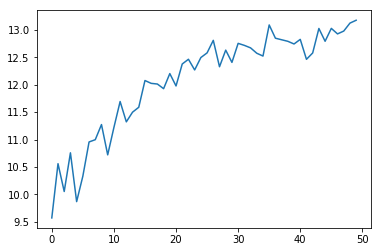

In [9]:
def plot_reward_per_episode(episode_rewards):
    import matplotlib.pyplot as plt
    episode_rewards = episode_rewards[0:]
    x = [i for i in range(len(episode_rewards)//100)]
    avg = [ sum(episode_rewards[i*100:(i+1)*100])/100 for i in range(len(episode_rewards)//100)]
    plt.plot(x, avg)

plot_reward_per_episode(episode_rewards)

In [10]:
test_env.set_validation(1)
for iterations in range(1):
    # Now we evaluate the trained model by taking greedy actions
    total1 = 0
    total2 = 0
    tc1 = 0
    tc2 = 0

    N=len(test_env.data)
    test_env.it = 0
    for it in range(N):
        observation = test_env.next_element() # Current observed state
        ob_cp = (copy.copy(observation[0]),copy.copy(observation[1]), copy.copy(observation[2]))
        #print("ob #:",observation[0])
        total_reward = 0
        agent.epsilon = 0
        i= 0
        done = False
        steps = 0
        cost = 0
        prev = []

        while True:
            if done:
                break;
            action = agent.get_action(observation,env)
            observation, reward, done, info = test_env.step(observation, action)
            total_reward += reward
            steps += 1
        prev = bool_feature(observation[1][:32])
        total1 += (test_env.rank(observation)[0])
        tc1 += observation[1][-1]

        observation = ob_cp
        done = False
        
        s2 = 0
        cost = 0
        while True:
            if done:
                break;
            actions = test_env.actions(observation)
            r = -1
            if (len(actions) != 1):
                r = random.randint(0,len(actions)-2)
            action = actions[r]
            #print("actions:",actions)
            if action != -1 and action < len(observation[1])-1:
                cost += env.costs[action]
            observation, reward, done, info = test_env.step(observation, action)
        total2+=(test_env.rank(observation)[0])
        #print()
        tc2 += observation[1][-1]

In [11]:
print("total final score RL:", total1)
print("total final score rand:", total2)
print("total final cost RL:", tc1/N)
print("total final cost rand:", tc2/N)

total final score RL: 9.34003382735323
total final score rand: 25.684693604959886
total final cost RL: 0.15901560184491376
total final cost rand: 0.12661055330769094


In [12]:
# Saving the network
#agent.to_pickle("somefile.pickle")